# Защита персональных данных клиентов

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


***Цель проекта:***
Защитить данные клиентов страховой компании «Хоть потоп» с использованием такого метода преобразования данных, который затрудняет восстановление персональной информации. 

***Задачи проекта:***
1. Доказать, что умножение матрицы признаков на обратимую матрицу не искажает предсказание модели линейной регрессии
2. Разработать алгоритм преобразования матрицы признаков
3. Обосновать выбор алгоритма
4. Проверить корректность работы алгоритма

## Загрузка библиотек

In [7]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

## Дополнительные функции

In [8]:
#Функция для генерации обратимой матрицы
def create_matrix(size):
    det = 0
    while det == 0:
        matrix = np.random.randint(100, size=(size, size))
        det = np.linalg.det(matrix)
    return matrix 

#Класс линейной регрессии
class LinerAnalysis():
    def fit(self, featires, target):
        self.x = featires
        self.y = target
        self.w = np.dot(np.dot(np.linalg.inv(np.dot(self.x.T, self.x)), self.x.T), self.y)
        
    def predict(self, features):
        return np.dot(features, self.w)

## Загрузка данных

In [9]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/insurance.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


### Проверка на пропуски

In [10]:
data.isna().sum()

Пол                  0
Возраст              0
Зарплата             0
Члены семьи          0
Страховые выплаты    0
dtype: int64

### Проверка на дубликаты

In [11]:
data.duplicated().sum()
data.index.nunique()


5000

В датасете 153 повторяющиеся записи, что допустимо. В датасете отсутсвуют персональные идентификаторы клиентов, а имеющиеся столбцы вполне могут совпасть у разных клиентов.

### Проверка на мультиколлинеарность

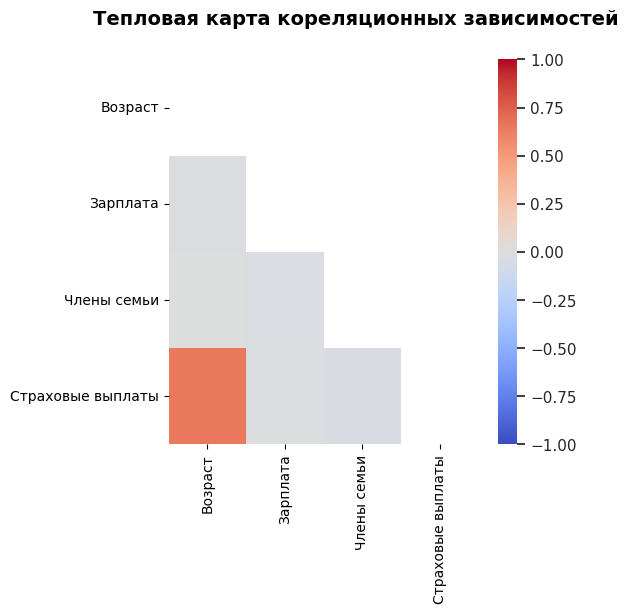

In [12]:
#Список числовых столбцов
numeric_columns = ['Возраст', 'Зарплата', 'Члены семьи', 'Страховые выплаты']

fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (5, 5))
# Заголовок фигуры
fig.suptitle\
('Тепловая карта кореляционных зависимостей', \
 fontsize=14, fontweight='bold');

upp_mat = np.triu(data[numeric_columns].corr())
sns.set(rc = {'figure.figsize':(5,5)})
sns.heatmap(data[numeric_columns].corr(),\
            vmin = -1, vmax = +1, annot = False, cmap = 'coolwarm', mask = upp_mat);

Судя по тепловой карте мультиколлинеарность в ДФ отсутсвует, а доминирующим признаком для определения результата предсказания может стать возраст. То есть теоретически можно было бы предсказать велчину страховых выплат следующим образом:
- стратифицировать все записи по возрасту
- предсказать страховую выплату как медиану по соответсвующей группе из тренирововчной выборки.

Эту "модель" можно было-бы использовать для проверки качества модели линейной регрессии. Так как у нас задача подбора не заявлена, в этом проекте мы этого делать не будем.

## Умножение матрицы признаков на обратимую матрицу

Задача:
Проверить, как меняются величина предсказания $\hat {\vec y}$ и вектор весовых коэффициентов $\vec w$ при умножении $X$ на обратимую матрицу $Z$. 

### Основные формулы Линейной регрессии

Уравнение линейной регресии (1):
$$ \hat {\vec y}  = X \cdot \vec w $$

Решение уравнения линейной регрессии в матричном виде (2):
$$X \cdot X^T \cdot \vec w = X^T \cdot \vec y$$

Решение уравнения для весовых коэффициентов (3):
$$\vec w = (X^T \cdot X \cdot)^{-1} \cdot X^T \cdot \vec y$$

Величина ошибки, определяющая качество модели (4):
$$ MSE = (\vec y - X \cdot \vec w)^T (\vec y - X \cdot \vec w)$$

Уравнение линейной регресии после изменения вектора признаков (5):
$$  \hat {\vec y_{new}}  = X \cdot Z \cdot \vec v $$
, где:

- $\hat {\vec y}$ - предсказание целевого признака (вектор - предикт);
- $\vec y$ - целевой признак (известный таргет);
- $X$ - матрица независимых признаков (до модификации);
- $\vec w$ - весовые коэффициенты модели линейной регрессии (пересчитываются при каждом обучении модели);
- $Z$ - обратимая матрица;
- $\hat {\vec y_{new}}$ - предсказание целевого признака после изменения матрицы признаков;
- $\vec v$ - весовые коэффициенты модели линейной регрессии после изменения матрицы признаков;

### Рассчеты для параметров модели при умножении признаков на обратимую матрицу

1. Умножим $X$ на обратимую матрицу $Z$, получим $X \cdot Z$
2. Учитывая неизменность $\vec y$, получаем, уравнение для весовых коэффициентов:
$$\vec v = ((X \cdot Z)^T \cdot (X \cdot Z) \cdot)^{-1} \cdot (X \cdot Z)^T \cdot \vec y$$
3. Проведем над ним ряд перобразований, чтобы найти $\vec v$:

    3.1 Раскроем скобки по правилу $(AB)^{T} = B^{T} \cdot A^{T} $:
$$\vec v = ((X \cdot Z)^T \cdot (X \cdot Z) \cdot)^{-1} \cdot Z^T \cdot X^T \cdot \vec y$$
$$\vec v = (Z^T \cdot X^T \cdot X \cdot Z \cdot)^{-1} \cdot Z^T \cdot X^T \cdot \vec y$$
    3.2 Воспользуемся свойством ассоциативности матричного произведения $((AB)С) = A(BC)$:
$$\vec v = (Z^T \cdot (X^T \cdot X \cdot Z \cdot))^{-1} \cdot Z^T \cdot X^T \cdot \vec y$$
$$\vec v = ((X^T \cdot X \cdot Z \cdot))^{-1} \cdot (Z^T)^{-1} \cdot Z^T \cdot X^T \cdot \vec y$$
$$\vec v = ((X^T \cdot X \cdot Z \cdot))^{-1} \cdot (E^T) \cdot X^T \cdot \vec y$$
$$\vec v = ((X^T \cdot X \cdot Z \cdot))^{-1} \cdot X^T \cdot \vec y$$
$$\vec v = Z^{-1} \cdot (X^T \cdot X )^{-1} \cdot X^T \cdot \vec y$$
    3.3 Учитывая формулу (3), заменим $(X^T \cdot X )^{-1} \cdot X^T \cdot \vec y$ на $\vec w$
$$\vec v = Z^{-1} \cdot \vec w$$

4. С учетом полученных результатов и формулы (1), рассчитаем новое предсказание:
$$ \hat {\vec y_{new}}  = X \cdot Z \cdot \vec v $$
$$ \hat {\vec y_{new}}  = X \cdot Z \cdot Z^{-1} \cdot \vec w $$
$$ \hat {\vec y_{new}}  = X \cdot \vec w $$
5. Таким образом новое предсказание совпало со старым:
$$ \hat {\vec y_{new}}  = \hat {\vec y} $$

Докажем, что при умножении $X$ на обратимую матрицу $Z$, величина метрики качества $MSE$ не изменится. 
$$ MSE_{new} = (\vec y_{new} - X \cdot Z \cdot \vec v)^T \cdot (\vec y_{new} - X \cdot Z \cdot \vec v)$$
1. С учетом ранее полученных равенств:
$$ MSE_{new} = (\vec y - X \cdot Z \cdot Z^{-1} \cdot \vec w)^T (\vec y - X \cdot Z \cdot Z^{-1} \cdot \vec w)$$
$$ MSE_{new} = (\vec y - X \cdot \vec w)^T (\vec y - X \cdot \vec w)$$

2. Таким образом новая ошибка совпала со старой:
$$ MSE_{new} = MSE$$

### Ответ

Таким образом, при умножении матрицы признаков на обратимую матрицу $Z$ возможно сохранение неизменной метрики качества и предсказаний модели линейной регресии, если при переобучении вектор весовых коэффициентов будет принят равным  $\vec v = Z ^{-1}\cdot \vec w $ 

## Алгоритм преобразования

### Обоснование выбора алгоритма

Для решения задачи обратимой модификации данных, содержащихся в матрице признаков, применим метод умножения на обратимую матрица. Этот метод является приемлимым, потому что он:
- не искажает результаты предсказаний модели линейной регрессии (доказательства в разделе 3)
- легко реализуется
- обратим (в любой момент можно умножить матрицу на обратную к использованной обратимой)
- позваляет модифицировать признаки так, что их восстановление потребует от злоумышленника временных затрат.

Следует отметить, что для реальных персональных данных при их передаче по незащищенным каналам данных использование данного метода весьма спорно. В реальных задачах стоит обратить внимание на ГОСТ-кие методы шифрования.  

### Описание алгоритма

1. Определяем необходимый размер обратимой матрицы (число строки и столбцов должно быть равно числу столбцов матрицы признаков)
2. Генерируем матрицу определенного размера, заполняя ее элементы случайными числами в диапазоне от 1 до 100 (чтобы сильно не повышать сложность вычислений)
3. Вычисляем определитель матрицы и проверяем, что он не равен 0. Если определитель равен нулю, генерируем другую матрицу.
4. Используем сгенерированную матрицу для преобразования матриц признаков во всех выборках (тренировочной, валидационной, тестовой).

## Проверка алгоритма

### Подготовка данных для обучения модели

In [13]:
#Выделяем матрицу признаков и целевой вектор
features = data.drop('Страховые выплаты', axis = 1)
target = data['Страховые выплаты']

#Расчитываем модифицированную матрицу признаков
matrix = create_matrix(features.shape[1])
change_features = np.dot(features, matrix)

#Делим выборки на тестовую и тренировочну
train_f, test_f, train_t, test_t = \
train_test_split(features, target, test_size=0.25, random_state = 12345)

ch_train_f, ch_test_f, train_t, test_t = \
train_test_split(change_features, target, test_size=0.25, random_state = 12345)

### Проверка модели линейной регрессии из библиотеки sklearn

In [14]:
#До модификации матрицы признаков
model = LinearRegression()
model.fit(train_f, train_t)
predict = model.predict(test_f)
r2 = r2_score(test_t, predict)
print(f'Величина r2 для линейной регрессии до модификаци матрицы признаков: {r2}')

#После модификации матрицы признаков
model.fit(ch_train_f, train_t)
predict = model.predict(ch_test_f)
r2 = r2_score(test_t, predict)
print(f'Величина r2 для линейной регрессии после модификаци матрицы признаков: {r2}')

Величина r2 для линейной регрессии до модификаци матрицы признаков: 0.435227571270266
Величина r2 для линейной регрессии после модификаци матрицы признаков: 0.43522757127023093


### Проверка модели линейной регрессии  (аналитическое решение)

In [15]:
#До модификации матрицы признаков
my_model = LinerAnalysis()
my_model.fit(train_f, train_t)
predict = my_model.predict(test_f)
r2 = r2_score(test_t, predict)
print(f'Величина r2 для линейной регрессии до модификаци матрицы признаков: {r2}')

#После модификации матрицы признаков
my_model = LinerAnalysis()
my_model.fit(ch_train_f, train_t)
predict = my_model.predict(ch_test_f)
r2 = r2_score(test_t, predict)
print(f'Величина r2 для линейной регрессии после модификаци матрицы признаков: {r2}')

Величина r2 для линейной регрессии до модификаци матрицы признаков: 0.3046402823898615
Величина r2 для линейной регрессии после модификаци матрицы признаков: 0.3046402859549492


### Вывод по разделу 6
Умножение матрицы признаков на обратимую матрицу не искажает результаты предсказания и не изменяет величину метрики качества R2

## ВЫВОДЫ

Цель проекта была реализация алгоритма защиты данных клиентов страховой компании «Хоть потоп» с использованием метода преобразования данных, который затрудняет восстановление персональной информации, но не вносит искажения в предсказания модели линейной регресии.

В процессе проекта проведена:
1. Загрузка и предварительная обработка данных:
 - проверка на пропуски (отсутсвуют);
 - проверка на дубликаты (присутсвуют, но не признаны ошибочными);
 - проверка на мультиколлинеарность (выявлена сильная положительная связь между возрастом клиентов и страховыми выплатами, предложено использовать это наблюдение в качестве бенчмарк приподборе моделей)

2. Подготовлен комплект модулей:
 - функция для генерации обратимой матрицы
 - класс для модели линейной регрессии, выполняющей регуляризацию аналитическим методом с использованием матричных операций

3. С применением теоретическихвыкладок, доказано, что умножение матрицы признаков наобратимую матрицу не влияет на результаты предсказания модели линейной регресии.

4. Подготовлен и обоснован алгоритм модификации (кодирования) персональных данных клиентов.

5. Подготовлены данные для машинного обучения:
 - выделен целевой признак (Страховые выплаты)
 - матрица признаков (остальные столбцы)
 - расчитана модифицированная матрица признаков (путем умножения основной на обратимую матрицу)
 - выборки разделены на тренировочную и тестовую

6. Созданы и обучены 4 модели линейной регрессии:
 - sklearn.linear_model.LinearRegression до модификации матрицы признаков
 - sklearn.linear_model.LinearRegression после модификации матрицы признаков
 - самописная модель до модификации матрицы признаков
 - самописная после модификации матрицы признаков

7. Проанализированы метрики качества обученных моделей. Выявлено, что модификация матрицы признаков не влияет на величину метрики качества ни той ни другой модели.
 
***Хотелось бы добавить, что представленные в ДФ данные (в том объеме, в котором они представлены) в соответсвии с ФЗ 152 не могут быть отнесены к персональным данным, так как они не идентифицируют субьекта персональных данных. Что очевидно и легко доказуемо даже тем, что в ДФ есть 153 повторяющиеся записи про разных клиентов. Поэтому корректнее было бы использовать иной термин. Например "чувствительные" данные, или данные заказчика, не подлежащие разглашению.***   